# IMDB-5000 Dataset Analysis

### Objective: Given information about a movie, predict whether it is terrible, bad, good or great. This is a classification problem.

### Dataset

The IMDB-5000 dataset is of size (5043,28), meaning we have 5043 observations (datapoints) and 28 features (variables). The variables are things like:

* Director name
* Duration
* Names of top 3 actors in the movie
* Language

### Dataset Exploration

We print the shape of the dataset to understand how many variables we are working with. We print the colums to see what each variable is.

Since the 'score' is the dependent variable, it is useful to move this column to the end of the dataset.

We need to know which columns contain `NaN` values as these need to be dealt with.

Dataset shape:  (5043, 28)
Dataset columns:  Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes'],
      dtype='object')
Columns with NaN values:
new shape:  (5043, 27)


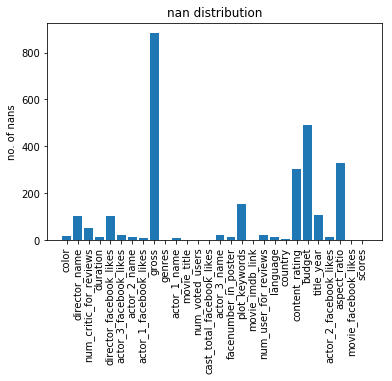

In [366]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# read in the dataset, print shape and column titles
dataset = pd.read_csv('movie_metadata.csv')
print("Dataset shape: ", dataset.shape)
print("Dataset columns: ", dataset.columns)

# move the dependent variable to the end of the dataframe
scores = list(dataset.iloc[:, -3].values)
dataset = dataset.drop(columns='imdb_score')
dataset['scores'] = scores

# count number of NaN values in the columns
print("Columns with NaN values:")
nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append(all_nans[i])

# plot the number of NaN values per column
plt.figure()
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.title('nan distribution')
plt.ylabel('no. of nans')

dataset = dataset.drop(columns='movie_imdb_link')
# we remove all rows where there is no score
dataset = dataset.dropna(axis=0,subset=['scores'])
print("new shape: ", dataset.shape)

From this quick analysis we can see that gross has >10% of rows as NaN. We shall just remove this column instead of attempting to impute values. 

Some of these other columns can be reasonably imputed, such as budget and aspect ratio. For the former we can set NaNs to the average/median of the column and for aspect ratio we can set NaNs to the most frequent value of the column.

shape of data before:  (5043, 27)
shape of data after:  (4857, 15)


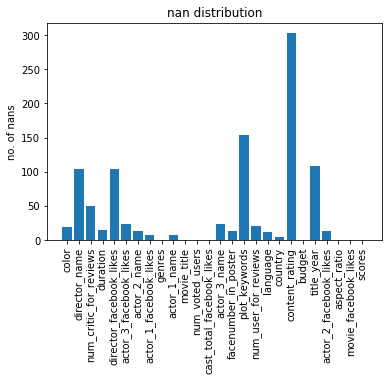

In [367]:
print("shape of data before: ", dataset.shape)

# Taking care of missing data
dataset = dataset.drop(columns='gross')

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer.fit(np.asarray(dataset['budget']).reshape(-1,1))
dataset['budget'] = imputer.transform(np.asarray(dataset['budget']).reshape(-1,1))

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(np.asarray(dataset['aspect_ratio']).reshape(-1,1))
dataset['aspect_ratio'] = imputer.transform(np.asarray(dataset['aspect_ratio']).reshape(-1,1))

nans = []
all_nans = dataset.isna().sum()

for i in range(len(all_nans)):
    nans.append(all_nans[i])

# plot the number of NaN values per column
plt.figure()
plt.bar(list(dataset.columns), nans)
plt.xticks([i for i in range(len(list(dataset.columns)))], list(dataset.columns), rotation='vertical')
plt.title('nan distribution')
plt.ylabel('no. of nans')

dataset = dataset.drop(columns=['color','plot_keywords','director_name','genres','movie_title','actor_1_name','actor_2_name','actor_3_name','language','country','content_rating'])

dataset = dataset.dropna(axis=0)
print("shape of data after: ", dataset.shape)

Text(0, 0.5, 'no. of movies')

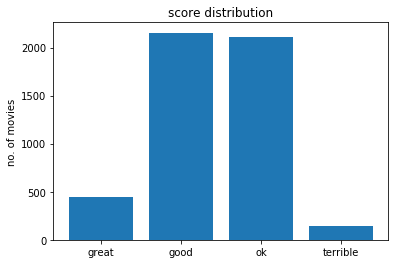

In [368]:
# put the score columns into categories
scores = list(dataset['scores'])
dataset.drop(columns='scores')
score_classes = []

for score in scores:
    if score >= 1.6 and score < 4.0:
        score_classes.append("terrible")
    elif score >= 4.0 and score < 6.5:
        score_classes.append("ok")
    elif score >= 6.5 and score < 7.8:
        score_classes.append("good")
    elif score >= 7.8 and score < 10.0:
        score_classes.append("great")
        
dataset['scores'] = score_classes

from collections import Counter
scores = Counter(list(dataset['scores']))

# plot the number of NaN values per column
plt.figure()
plt.bar(scores.keys(), scores.values())
plt.xticks([i for i in range(len(list(scores.keys())))], list(scores.keys()),)
plt.title('score distribution')
plt.ylabel('no. of movies')

In [369]:
from sklearn.feature_selection import VarianceThreshold

correlated_features = set()
correlation_matrix = dataset.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
print(len(correlated_features))
print(correlated_features)

dataset.drop(labels=correlated_features, axis=1, inplace=True)
print(dataset.columns)

2
{'num_user_for_reviews', 'cast_total_facebook_likes'}
Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'facenumber_in_poster', 'budget', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
       'scores'],
      dtype='object')


### Now we split the dataset into the independent (X) and dependent variables (y)

#### X is a matrix with 27 columns, y is a vector

In [370]:
print(dataset.columns)

X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1].values

# Encoding the Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_le = le.fit_transform(y)

"""
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('cat', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
"""
"""
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y.reshape(-1,1)).toarray()
print(X.shape)
print(y.shape)
"""

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'num_voted_users',
       'facenumber_in_poster', 'budget', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
       'scores'],
      dtype='object')


'\nfrom sklearn.preprocessing import OneHotEncoder\nohe = OneHotEncoder()\ny = ohe.fit_transform(y.reshape(-1,1)).toarray()\nprint(X.shape)\nprint(y.shape)\n'

In [371]:
# Feature Scaling (necessary for NNs)
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

In [372]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size = 0.1, random_state = 0)

In [387]:
# Training the Naive Bayes model on the Training set
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)

y_pred = NB.predict(X_test)

a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy is: 31.275720164609055
[[ 40  26  65  74]
 [ 15  25   6   5]
 [ 14   4  70 123]
 [  1   0   1  17]]


In [388]:
# Training the K-NN model on the Training set
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
KNN.fit(X_train, y_train)

y_pred = KNN.predict(X_test)

a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy is: 58.8477366255144
[[131   6  67   1]
 [ 25  20   6   0]
 [ 76   0 135   0]
 [  5   0  14   0]]


In [392]:
# Training the Kernel SVM model on the Training set
from sklearn.svm import SVC
SVM = SVC(kernel = 'rbf', random_state = 0)
SVM.fit(X_train, y_train)

y_pred = SVM.predict(X_test)

from sklearn.metrics import accuracy_score
a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix, f1_score
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

/Users/Ricardo/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy is: 63.991769547325106
[[129   2  74   0]
 [ 32  15   4   0]
 [ 44   0 167   0]
 [  2   0  17   0]]


In [390]:
# Training the Random Forest Classification model on the Training set
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', random_state = 0)
RFC.fit(X_train, y_train)

y_pred = RFC.predict(X_test)

a = accuracy_score(y_pred,y_test)
print('Accuracy is:', a*100)

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

Accuracy is: 65.63786008230453
[[135   4  66   0]
 [ 29  22   0   0]
 [ 50   0 161   0]
 [  1   0  17   1]]


In [341]:
from sklearn.preprocessing import OneHotEncoder
print(y.shape)
ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y.reshape(-1,1)).toarray()
print(y_ohe.shape)

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size = 0.1, random_state = 0)

(4857,)
(4857, 4)


In [359]:
# Create ANN
import keras
from keras.models import Sequential
from keras.layers import Dense

# initialise the ANN
Net = Sequential()

# Add input layer + first hidden layer
Net.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))

# Add second & third hidden layers
Net.add(Dense(units = 12, kernel_initializer = 'uniform', activation = 'relu'))
Net.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Add the output layer
Net.add(Dense(units = 4, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compile the Neural Network
Net.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [360]:
# fit ANN to the training set
history = Net.fit(X_train, y_train, batch_size = 64, validation_data = (X_test,y_test), epochs = 200)

Train on 4371 samples, validate on 486 samples
Epoch 1/200
4371/4371 [==============================] - 1s 154us/step - loss: 1.3621 - accuracy: 0.4313 - val_loss: 1.3061 - val_accuracy: 0.4342
Epoch 2/200
4371/4371 [==============================] - 0s 22us/step - loss: 1.1349 - accuracy: 0.4338 - val_loss: 1.0831 - val_accuracy: 0.4342
Epoch 3/200
4371/4371 [==============================] - 0s 20us/step - loss: 1.0170 - accuracy: 0.4562 - val_loss: 1.0586 - val_accuracy: 0.4218
Epoch 4/200
4371/4371 [==============================] - 0s 21us/step - loss: 0.9893 - accuracy: 0.4475 - val_loss: 1.0296 - val_accuracy: 0.4383
Epoch 5/200
4371/4371 [==============================] - 0s 21us/step - loss: 0.9515 - accuracy: 0.4706 - val_loss: 0.9797 - val_accuracy: 0.4527
Epoch 6/200
4371/4371 [==============================] - 0s 21us/step - loss: 0.9091 - accuracy: 0.4754 - val_loss: 0.9426 - val_accuracy: 0.4486
Epoch 7/200
4371/4371 [==============================] - 0s 21us/step - loss

4371/4371 [==============================] - 0s 26us/step - loss: 0.7744 - accuracy: 0.6555 - val_loss: 0.8014 - val_accuracy: 0.6502
Epoch 57/200
4371/4371 [==============================] - 0s 23us/step - loss: 0.7744 - accuracy: 0.6545 - val_loss: 0.8036 - val_accuracy: 0.6481
Epoch 58/200
4371/4371 [==============================] - 0s 25us/step - loss: 0.7762 - accuracy: 0.6568 - val_loss: 0.8079 - val_accuracy: 0.6481
Epoch 59/200
4371/4371 [==============================] - 0s 23us/step - loss: 0.7742 - accuracy: 0.6568 - val_loss: 0.8111 - val_accuracy: 0.6399
Epoch 60/200
4371/4371 [==============================] - 0s 22us/step - loss: 0.7760 - accuracy: 0.6577 - val_loss: 0.8022 - val_accuracy: 0.6523
Epoch 61/200
4371/4371 [==============================] - 0s 23us/step - loss: 0.7731 - accuracy: 0.6539 - val_loss: 0.8062 - val_accuracy: 0.6399
Epoch 62/200
4371/4371 [==============================] - 0s 20us/step - loss: 0.7719 - accuracy: 0.6568 - val_loss: 0.7962 - val_a

Epoch 112/200
4371/4371 [==============================] - 0s 27us/step - loss: 0.7528 - accuracy: 0.6735 - val_loss: 0.7888 - val_accuracy: 0.6564
Epoch 113/200
4371/4371 [==============================] - 0s 22us/step - loss: 0.7550 - accuracy: 0.6635 - val_loss: 0.7907 - val_accuracy: 0.6605
Epoch 114/200
4371/4371 [==============================] - 0s 18us/step - loss: 0.7530 - accuracy: 0.6726 - val_loss: 0.7831 - val_accuracy: 0.6626
Epoch 115/200
4371/4371 [==============================] - 0s 19us/step - loss: 0.7510 - accuracy: 0.6767 - val_loss: 0.7894 - val_accuracy: 0.6564
Epoch 116/200
4371/4371 [==============================] - 0s 18us/step - loss: 0.7519 - accuracy: 0.6728 - val_loss: 0.7855 - val_accuracy: 0.6605
Epoch 117/200
4371/4371 [==============================] - 0s 18us/step - loss: 0.7519 - accuracy: 0.6756 - val_loss: 0.7855 - val_accuracy: 0.6646
Epoch 118/200
4371/4371 [==============================] - 0s 20us/step - loss: 0.7507 - accuracy: 0.6733 - val_

4371/4371 [==============================] - 0s 25us/step - loss: 0.7400 - accuracy: 0.6756 - val_loss: 0.7973 - val_accuracy: 0.6646
Epoch 168/200
4371/4371 [==============================] - 0s 25us/step - loss: 0.7396 - accuracy: 0.6813 - val_loss: 0.7897 - val_accuracy: 0.6687
Epoch 169/200
4371/4371 [==============================] - 0s 21us/step - loss: 0.7375 - accuracy: 0.6806 - val_loss: 0.7966 - val_accuracy: 0.6605
Epoch 170/200
4371/4371 [==============================] - 0s 18us/step - loss: 0.7377 - accuracy: 0.6770 - val_loss: 0.7931 - val_accuracy: 0.6667
Epoch 171/200
4371/4371 [==============================] - 0s 18us/step - loss: 0.7392 - accuracy: 0.6786 - val_loss: 0.7885 - val_accuracy: 0.6728
Epoch 172/200
4371/4371 [==============================] - 0s 18us/step - loss: 0.7390 - accuracy: 0.6790 - val_loss: 0.7952 - val_accuracy: 0.6646
Epoch 173/200
4371/4371 [==============================] - 0s 18us/step - loss: 0.7384 - accuracy: 0.6822 - val_loss: 0.7892 -

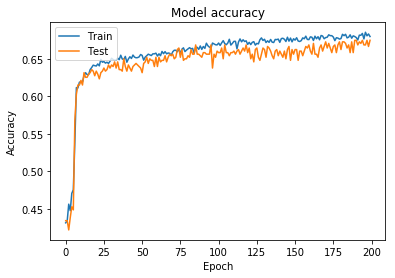

Accuracy is: 67.48971193415639


In [364]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

y_pred = Net.predict(X_test)

# Converting predictions to label
pred_classes = list()
for i in range(len(y_pred)):
    pred_classes.append(np.argmax(y_pred[i]))

# Converting one hot encoded test label to label
test_classes = list()
for i in range(len(y_test)):
    test_classes.append(np.argmax(y_test[i]))

from sklearn.metrics import accuracy_score
a = accuracy_score(pred_classes,test_classes)
print('Accuracy is:', a*100)